# Cleaning Up the Given Dataset and Performing EDA

### Step 1: Setting Up the Environment

Installing required packages using pip:
Selenium and Beautiful Soup are used for web scraping

In [ ]:
!pip install selenium
!pip install BeautifulSoup4

Contractions library changes the contractions to expanded form
Eg: They've -> They have

In [ ]:
!pip install contractions

     |████████████████████████████████| 266kB 4.3MB/s 
     |████████████████████████████████| 327kB 7.1MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85389 sha256=031eb415b4f6a09254d98af586c3f7af1875dd2cd36ea65d1909a9996fbb8eef
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


Importing Necessary Packages

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
from selenium import webdriver
from bs4 import BeautifulSoup
import requests
from tqdm.notebook import tqdm
import re
import seaborn as sn
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import strip_numeric,strip_punctuation,strip_short,strip_non_alphanum,remove_stopwords
import contractions

In [ ]:
!apt-get update 
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: use options instead of chrome_options
  if __name__ == '__main__':


### Step 2: Loading the data and initial analysis

In [ ]:
data = pd.read_csv('drive/My Drive/flipkart_com-ecommerce_sample - flipkart_com-ecommerce_sample - flipkart_com-ecommerce_sample.csv')

Initial analysis of the data shows that the following features may be useful:


1.   Product URL: To fetch additional data about the product
2.   Product Category Tree: To fetch primary category of the product
3.   Retail Price: Might be useful 
4.   Image: Can be used to create a hybrid model
5.   Description: Primary feature field
6.   Brand



In [ ]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


In [ ]:
data.describe()

,retail_price,discounted_price
count,19922.000000,19922.000000
mean,2979.206104,1973.401767
std,9009.639341,7333.586040
min,35.000000,35.000000
25%,666.000000,350.000000
50%,1040.000000,550.000000
75%,1999.000000,999.000000
max,571230.000000,571230.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  20000 non-null  object 
 1   crawl_timestamp          20000 non-null  object 
 2   product_url              20000 non-null  object 
 3   product_name             20000 non-null  object 
 4   product_category_tree    20000 non-null  object 
 5   pid                      20000 non-null  object 
 6   retail_price             19922 non-null  float64
 7   discounted_price         19922 non-null  float64
 8   image                    19997 non-null  object 
 9   is_FK_Advantage_product  20000 non-null  bool   
 10  description              19998 non-null  object 
 11  product_rating           20000 non-null  object 
 12  overall_rating           20000 non-null  object 
 13  brand                    14136 non-null  object 
 14  product_specifications

Dropping some irrelevant fields since:

Each product would have a different ID, which is not useful for predictions

Timestamp is not needed as well

In [ ]:
data.drop(['uniq_id','crawl_timestamp','pid','is_FK_Advantage_product'],axis = 1,inplace = True)

Looking at the unique product categories, we can see that there are too many categories, and primary category is separated by '>>'

Some products may not have a category defined


In [ ]:
data['product_category_tree'].value_counts()

["Jewellery >> Necklaces & Chains >> Necklaces"]                                                                                                                     1567
["Jewellery >> Rings"]                                                                                                                                                710
["Automotive >> Accessories & Spare parts >> Car Interior & Exterior >> Car Interior >> Car Mats"]                                                                    522
["Jewellery >> Bangles, Bracelets & Armlets >> Bangles"]                                                                                                              430
["Tools & Hardware >> Tools >> Gardening Tools >> Plant Containers & Sets >> Plant Container Sets"]                                                                   332
                                                                                                                                                      

### Step 3: Cleaning product Categories

Initializing a new column to store primary category

In [ ]:
data['Category'] = 'NA'

In [ ]:
del_idx = []

Steps Followed:

1. If a valid product category is present, filter out the main category
2. If category is not found in the data, post a request to flipkart using product url and fetch category using beautiful soup find function
3. If a category is still not found, append the index to a list

In [ ]:
for i in tqdm(range(len(data))):
  cat = ''
  if '>>' in data['product_category_tree'][i]:
    cat = re.sub('\["','',data['product_category_tree'][i].split('>>')[0]).rstrip().lstrip()
    data['Category'][i] = cat
  else:
    try:
      content = requests.get(data['product_url'][i])
      soup = BeautifulSoup(content.text,'html.parser')
      # Class figured out by analyzing the source code of flipkart webpage
      cat = soup.find_all('a',attrs = {'class':'_2whKao'})[1].get_text()
      data['Category'][i] = cat
    except IndexError:
      del_idx.append(i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
print('Total entries removed due to unavailable label = ',len(del_idx))

Total entries removed due to unavailable label =  260


In [ ]:
data.shape

(20000, 12)

Looking at the product categories without primary category

(These can be manually figured out if needed)

In [ ]:
data.iloc[del_idx].product_category_tree.unique()

array(['["Eternal Gandhi Super Series Crystal Paper Weight..."]',
       '["Bengal Blooms Rose Artificial Plant  with Pot (3..."]',
       '["BuildTrack PIR Wireless Motion Sensor - One Swit..."]',
       '["MASARA Solid Women\'s Straight Kurta"]',
       '["Noor Embroidered Women\'s Straight Kurta"]',
       '["Cellbazaar Blackberry 8520 WHITE LCD LCD (YIT-562)"]',
       '["Dressberry Gold Synthetic  Clutch"]',
       '["Mast & Harbour Black Synthetic  Clutch"]',
       '["Sisel Printed Poly Cotton Women\'s Stole"]',
       '["Knight Ace Kraasa Sports Running Shoes, Cycling ..."]',
       '["Indistar Self Design Viscose Women\'s Stole"]',
       '["Glacier Running Shoes"]',
       '["Dressberry Black Synthetic  Clutch"]',
       '["Asics Gel-Cumulus 17 Running Shoes"]',
       '["Mast & Harbour Gold Synthetic  Clutch"]',
       '["Dressberry Orange Synthetic  Clutch"]',
       '["Dressberry Green Synthetic  Clutch"]', '["Escan Lace Up"]',
       '["Nine Maternity Wear Women\'s Fit an

Deleting products without primary category since, only 260 such entries are present

In [ ]:
data.drop(index = del_idx,inplace = True)

In [ ]:
data.shape

(19740, 12)

Looking at unique categories, we can see some duplicates

In [ ]:
data['Category'].value_counts()

Clothing                             6198
Jewellery                            3534
Footwear                             1237
Mobiles & Accessories                1099
Automotive                           1012
Home Decor & Festive Needs            929
Beauty and Personal Care              710
Home Furnishing                       705
Kitchen & Dining                      647
Computers                             580
Watches                               530
Baby Care                             483
Tools & Hardware                      391
Toys & School Supplies                330
Pens & Stationery                     314
Bags, Wallets & Belts                 265
Furniture                             182
Sports & Fitness                      166
Cameras & Accessories                  85
Home Improvement                       84
Health & Personal Care Appliances      43
Sunglasses                             37
Gaming                                 35
Pet Supplies                      

Fixing duplicate entries

In [ ]:
mapping = {'Home Decor':'Home Decor & Festive Needs',
           'Home & Kitchen':'Kitchen & Dining',
           'Sports':'Sports & Fitness',
           'Beauty and Grooming':'Beauty and Personal Care',
           'Automotive Accessories':'Automotive',
           'Sunglasses':'Eyewear'}

In [ ]:
for key,target in mapping.items():
  data['Category'] = data['Category'].replace(key,target)

Removing Bottom 10 Categories due to inadequate number of data points

In [ ]:
to_remove = data['Category'].value_counts()[-10:].index

In [ ]:
data = data[~data['Category'].isin(to_remove)]

Finally, 22 categories are shortlisted

In [ ]:
data['Category'].value_counts()

Clothing                             6198
Jewellery                            3534
Footwear                             1237
Mobiles & Accessories                1099
Automotive                           1014
Home Decor & Festive Needs            932
Beauty and Personal Care              712
Home Furnishing                       705
Kitchen & Dining                      673
Computers                             580
Watches                               530
Baby Care                             483
Tools & Hardware                      391
Toys & School Supplies                330
Pens & Stationery                     314
Bags, Wallets & Belts                 265
Furniture                             182
Sports & Fitness                      167
Cameras & Accessories                  85
Home Improvement                       84
Eyewear                                47
Health & Personal Care Appliances      43
Name: Category, dtype: int64

### Step 4: Visualizing Cleaned Data

##### 1. Plotting count of Categories

In [ ]:
labels = data['Category'].value_counts().index
vals = data['Category'].value_counts().values

In [ ]:
data.shape

(19605, 12)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0.5, 'Categories'), Text(0.5, 0, 'Count')]

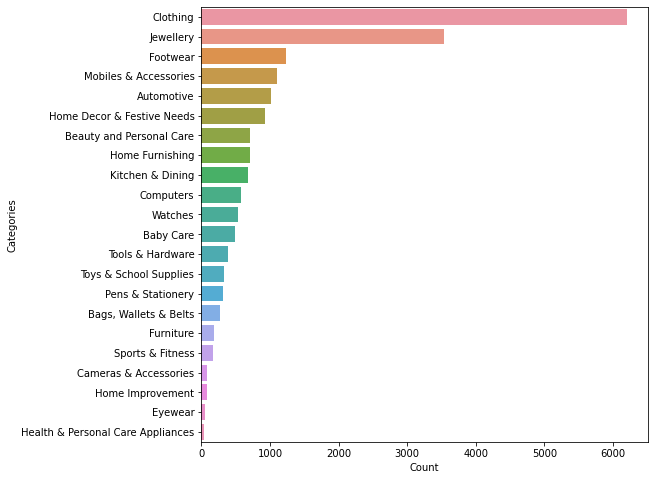

In [ ]:
plt.figure(figsize = (8,8))
ax = sn.barplot(vals,labels)
ax.set(xlabel = 'Count',ylabel = 'Categories')

Removing products where description is not given (only 3 such entries are present)

In [ ]:
data.isna().sum()

product_url                  0
product_name                 0
product_category_tree        0
retail_price                74
discounted_price            74
image                        3
description                  2
product_rating               0
overall_rating               0
brand                     5846
product_specifications      13
Category                     0
dtype: int64

In [ ]:
data.columns

Index(['product_url', 'product_name', 'product_category_tree', 'retail_price',
       'discounted_price', 'image', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications', 'Category'],
      dtype='object')

In [ ]:
data.dropna(subset = ['description'],inplace = True)

In [ ]:
data.shape

(19603, 12)

In [ ]:
data['description'][0]

"Key Features of Alisha Solid Women's Cycling Shorts Cotton Lycra Navy, Red, Navy,Specifications of Alisha Solid Women's Cycling Shorts Shorts Details Number of Contents in Sales Package Pack of 3 Fabric Cotton Lycra Type Cycling Shorts General Details Pattern Solid Ideal For Women's Fabric Care Gentle Machine Wash in Lukewarm Water, Do Not Bleach Additional Details Style Code ALTHT_3P_21 In the Box 3 shorts"

###Step 5: Cleaning Descriptions

In [ ]:
cleaned_desc = list()

Using gensim, the following processes were applied:

1. Convert the description to lower case
2. Convert contractions to expanded form
3. Remove Punctuations
4. Remove Non alphanumeric values
5. Remove numbers
6. Remove StopWords
7. Remove stray characters of length 1

In [ ]:
def cleanup():
  for i in tqdm(data.description):
    text = i.lower()
    text = contractions.fix(text) 
    text =  strip_punctuation(text)
    text = strip_non_alphanum(text)
    text = strip_numeric(text)
    text = remove_stopwords(text)
    text = strip_short(text,minsize = 1)
    cleaned_desc.append(text)

In [ ]:
cleanup()

Cleaned Data was added to a final dataframe, which was stored in Google Drive for further use

In [ ]:
final_data = pd.DataFrame()

In [ ]:
data.columns

Index(['product_url', 'product_name', 'product_category_tree', 'retail_price',
       'discounted_price', 'image', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications', 'Category'],
      dtype='object')

In [ ]:
final_data['Product Name'] = data['product_name']
final_data['Description'] = cleaned_desc
final_data['Image'] = data['image']
final_data['Category'] = data['Category']

In [ ]:
final_data.to_csv('finaldata.csv')

In [ ]:
!cp finaldata.csv drive/My\ Drive

###Step 6: Analyzing Given Data using Visualizations

#####1. Plotting wordcloud of the descriptions, some prominent words are: key, features, buy, solid,sticker,etc

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='white',max_words=50,width=250,height=250)

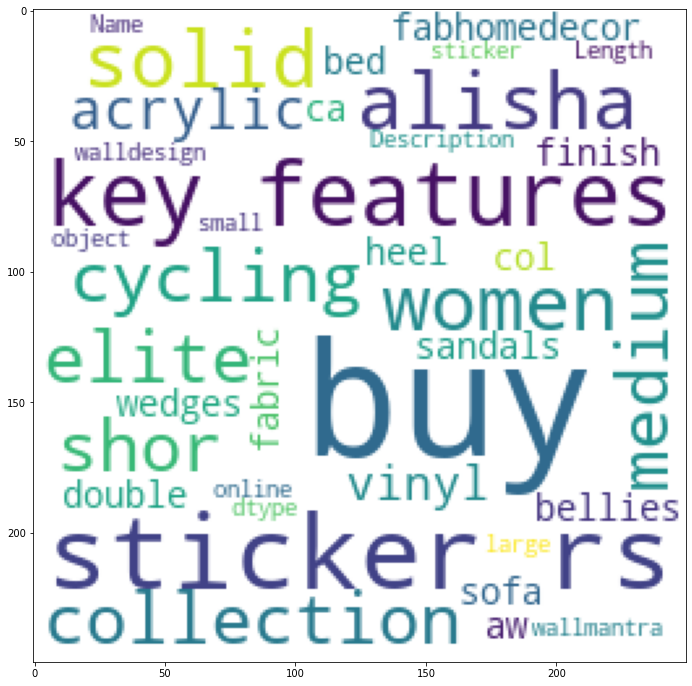

In [ ]:
wordcloud.generate(str(final_data['Description']))
plt.rcParams['figure.figsize'] = (12,12)
plt.imshow(wordcloud)

#####2. Plotting count of most prominent words for each product category

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def calc_word_freq(final_data):
  cv=CountVectorizer()
  cats = final_data.Category.unique()
  for c in cats:
    sub_df = final_data[final_data['Category']==c]  
    vect=cv.fit_transform(sub_df['Description']) 
    counts=pd.DataFrame(vect.toarray(),columns=cv.get_feature_names())
    counts=pd.DataFrame(counts.sum().sort_values(ascending=False).head(10))
    plot_words([counts],[c])

def plot_words(df, cat):
    count = 0
    fig = plt.figure(figsize=(6,6))
    for idx, data in enumerate(df):
        count += 1
        sn.barplot(x = 0,y = data.index,data = data)
        plt.title(f" {cat[idx]}")
        plt.xlabel("Frequency")
        plt.show()

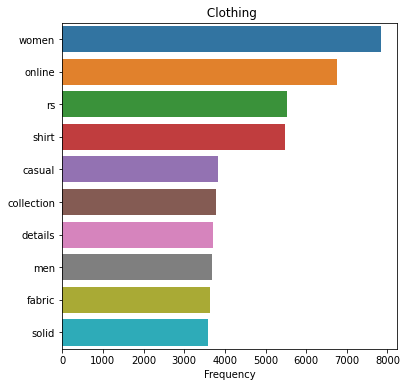

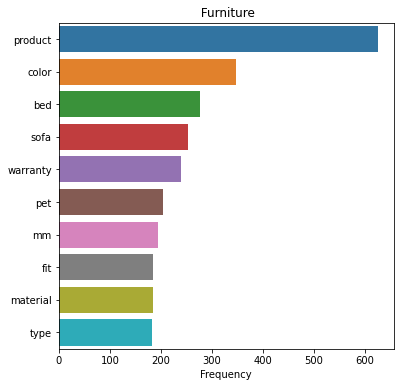

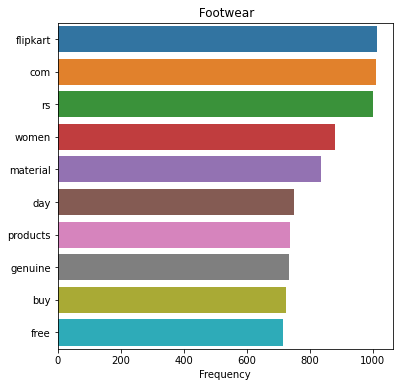

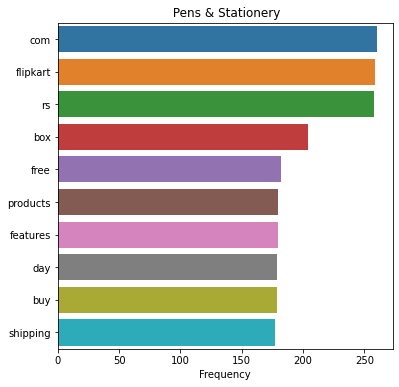

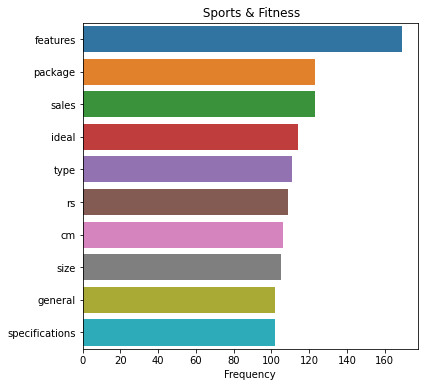

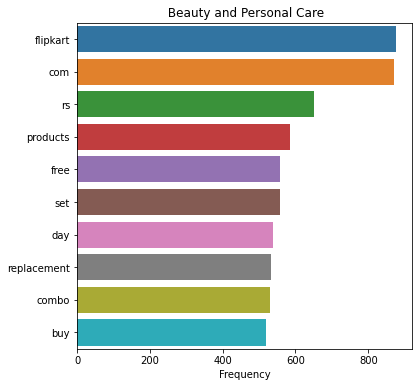

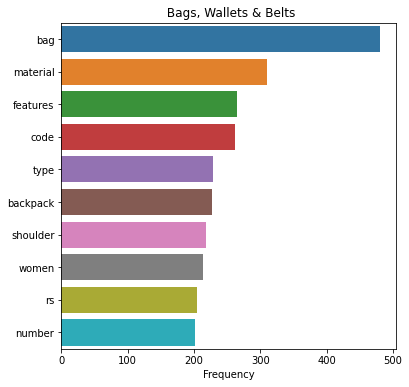

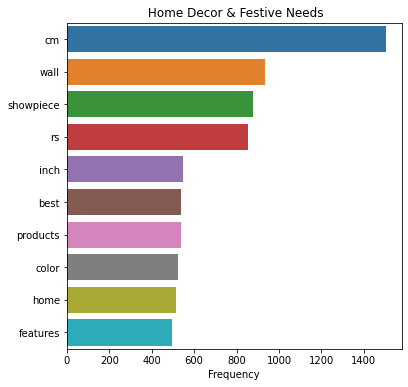

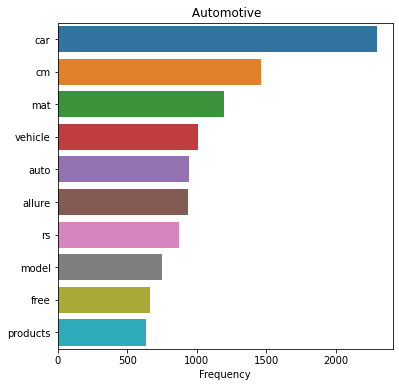

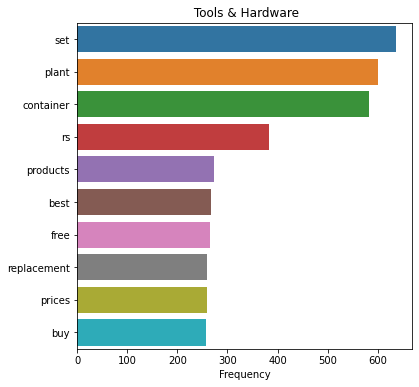

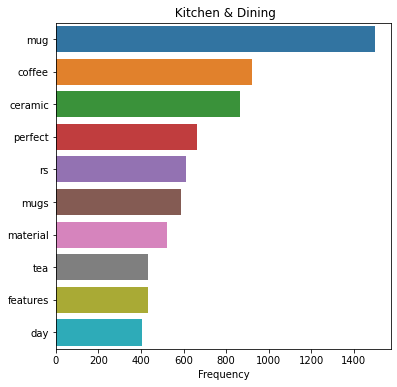

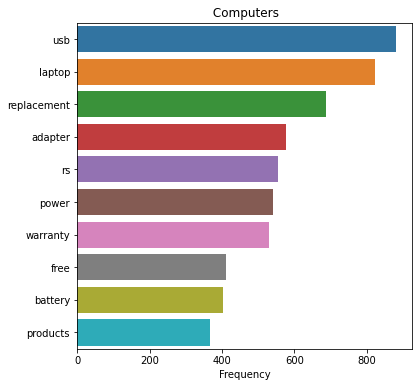

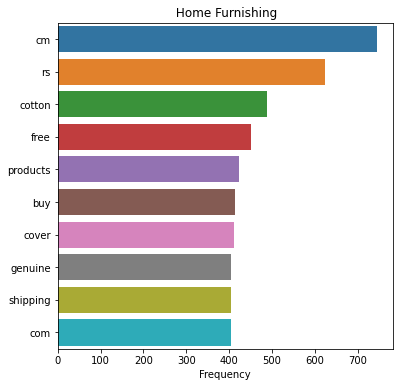

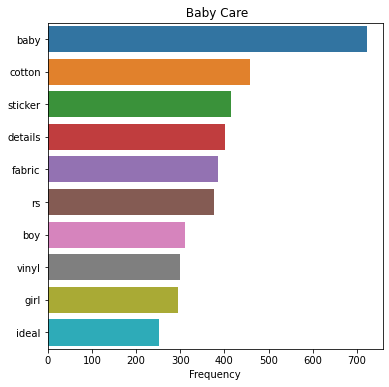

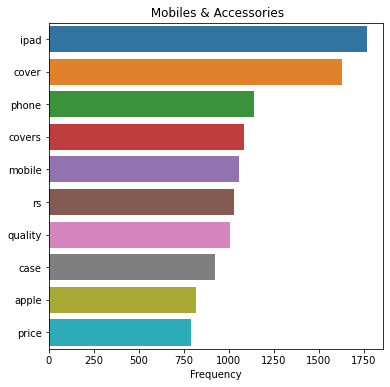

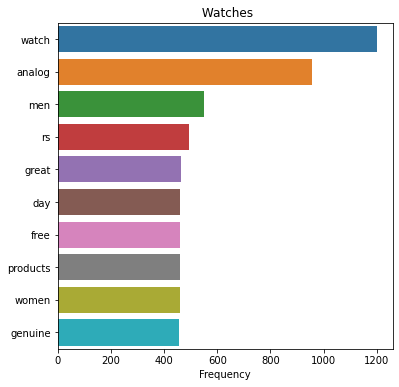

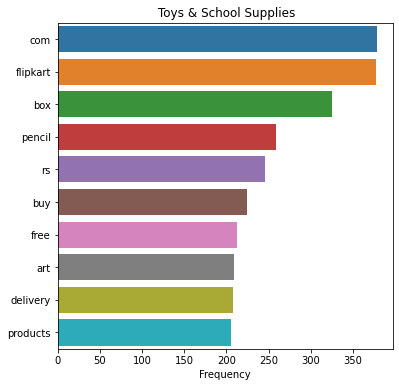

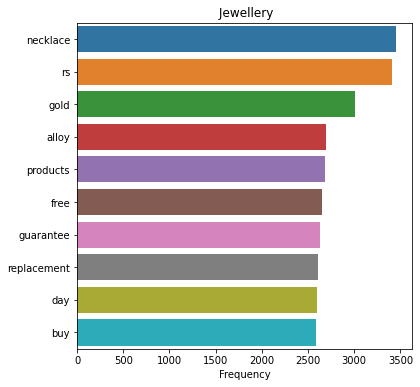

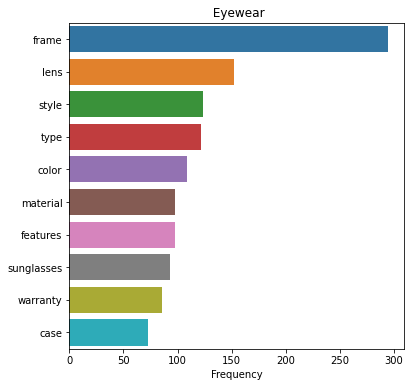

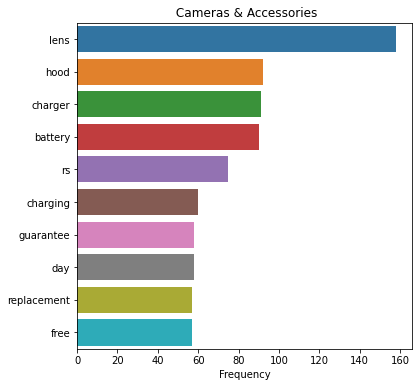

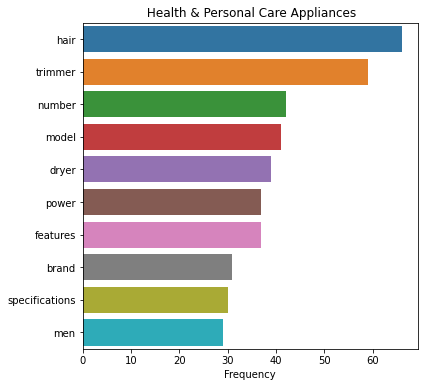

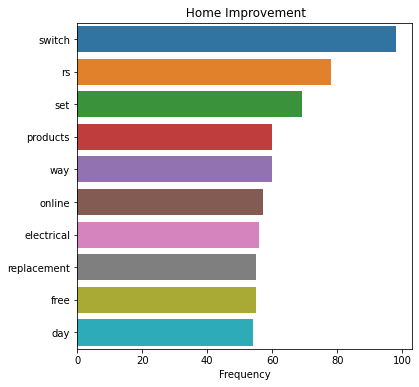

In [ ]:
calc_word_freq(final_data)

#####3. Plotting Distribution of Length of Descriptions and calculating the average word length

In [ ]:
desc_lens = []
for i in final_data.Description:
  desc_lens.append(len(i.split()))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Length Distribution of Descriptions in the Dataset')

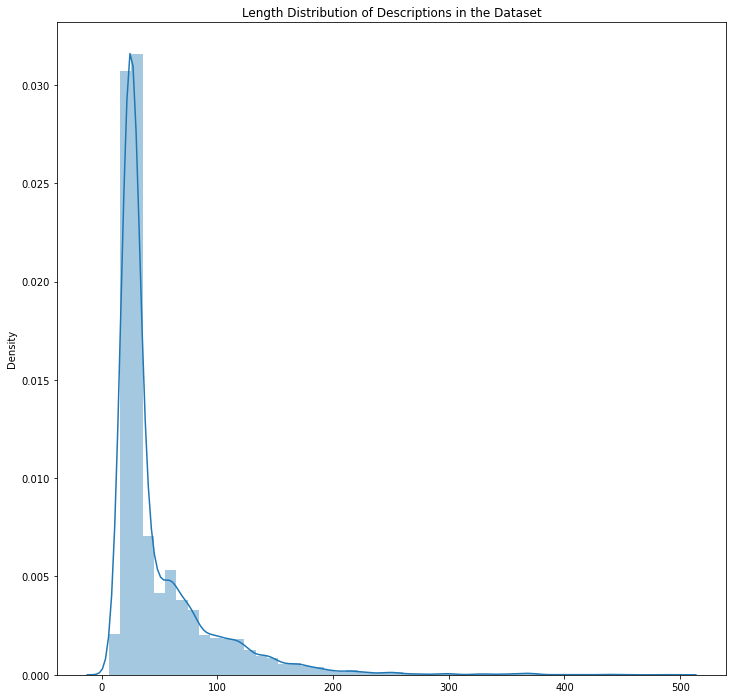

In [ ]:
sn.distplot(desc_lens)
plt.title('Length Distribution of Descriptions in the Dataset')

In [ ]:
print('Average Description Length = ',np.mean(desc_lens))

Average Description Length =  47.88134469213896


In [ ]:
final_data['Desc Length'] = desc_lens

It can be seen that Eyewear, Kitchen and Dining have the maximum average word length and Jewellery has the minimum average word length

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text major ticklabel objects>)

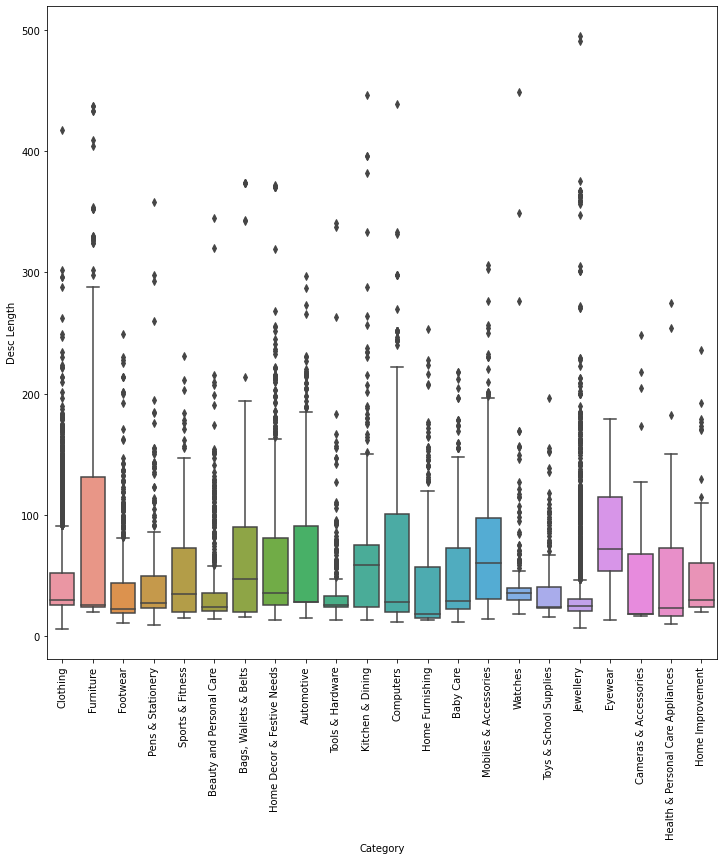

In [ ]:
plt.figure(figsize = (12,12))
sn.boxplot('Category','Desc Length',data = final_data)
plt.xticks(rotation = 90)

In [ ]:
!pip freeze ->req1.txt